In [1]:
import cv2
import numpy as np
import pandas as pd
import json
import re
import collections
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.utils import to_categorical
import pickle
from time import time
import string
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from PIL import Image
from keras import optimizers
import matplotlib.pyplot as plt
import pyttsx3
from numpy import loadtxt
from keras.models import load_model

Using TensorFlow backend.


In [6]:
# collecting caption data from json file

def collectCaption(path):
    with open(path) as f:
        captions = json.load(f)
    return captions

In [7]:
captions = collectCaption("./Dataset/annotations/captions_train2017.json")

In [8]:
print(captions.keys())

dict_keys(['info', 'licenses', 'images', 'annotations'])


In [9]:
# mapping ids to its images.
id_img = {}
for x in captions['images']:
#     c +=1
    id_img[str(x['id'])] = x['file_name']
#     if c==10:
    

In [10]:
with open("./final Data/id_img.pkl","wb") as f:
    pickle.dump(id_img,f)

In [11]:
print(id_img["391895"])

000000391895.jpg


In [12]:
description = {}
for anno in captions['annotations']:
    img_id = str(anno['image_id'])
    cap = anno['caption']
    
    img_name = id_img[img_id]
    if description.get(img_name) is None:
        description[img_name] = []
    if len(description[img_name]) <= 5:
        description[img_name].append(cap)
    

In [13]:
description['000000522418.jpg']

['A woman wearing a net on her head cutting a cake. ',
 'A woman cutting a large white sheet cake.',
 'A woman wearing a hair net cutting a large sheet cake.',
 'there is a woman that is cutting a white cake',
 "A woman marking a cake with the back of a chef's knife. "]

In [14]:
# data cleaning

def clean_text(sent):
    sent = sent.lower()
    sent = re.sub("[^a-z]+"," ",sent)
    sent = sent.split()
    
    sent = [s for s in sent if len(s)>1]
    sent = " ".join(sent)
    return sent

In [15]:
# cleaning description

for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
description['000000522418.jpg']

['woman wearing net on her head cutting cake',
 'woman cutting large white sheet cake',
 'woman wearing hair net cutting large sheet cake',
 'there is woman that is cutting white cake',
 'woman marking cake with the back of chef knife']

In [17]:
# with open("discription.txt","w") as f:
#     f.write(str(description))

In [18]:
# create a vocab
description = None
with open("Data\discription.txt","r") as f:
    description = f.read()
json_acceptable_string = description.replace("'","\"")
description = json.loads(json_acceptable_string)


In [19]:
# vocab

vocab = set()
for key in description.keys():
    [vocab.update(sent.split()) for sent in description[key]]
print(len(vocab))

26440


In [20]:
# total no. of words accross the descriptionabs
total_words = []

for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]
print(len(total_words))

5210675


In [21]:
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt))

26440


In [22]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True, key=lambda x:x[1])

#filter
threshold = 4
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]


In [23]:
print(len(total_words))

10100


In [24]:
# creating train images
train_img_id = []
for key,img in id_img.items():
    train_img_id.append(img)

In [25]:
print(train_img_id[:4])

['000000391895.jpg', '000000522418.jpg', '000000184613.jpg', '000000318219.jpg']


In [26]:
len(train_img_id)

118287

In [27]:
# prepare Description for the Training Data
# Tweak - Add <s> and <e> toen to our traing data

train_descriptions = {}

for img_id in train_img_id:
    train_descriptions[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "<s> " + cap + " <e>"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["000000391895.jpg"]

['<s> man with red helmet on small moped on dirt road <e>',
 '<s> man riding motor bike on dirt road on the countryside <e>',
 '<s> man riding on the back of motorcycle <e>',
 '<s> dirt path with young person on motor bike rests to the foreground of verdant area with bridge and background of cloud wreathed mountains <e>',
 '<s> man in red shirt and red hat is on motorcycle on hill side <e>']

In [ ]:

= "D:/programming/Machine learning and Deep learning/Projects/minor1.0/videoCaptioning for blinds/Datasets/coco/train2017/"

In [2]:
# Transfer Learning
# - images-->Features

#Step-1 Download Pre-trained model--resnet-50

model = ResNet50(weights='imagenet',input_shape=(224,224,3))

W1126 12:39:28.499868 85920 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1126 12:39:28.538715 85920 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1126 12:39:28.552721 85920 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1126 12:39:28.647423 85920 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
model.layers[-2].output

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

model_new.save(('./final Data/resnet' +'.h5'))

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    #Normalization
    
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vect = model_new.predict(img)
    feature_vect = feature_vect.reshape((-1,))
    return feature_vect
    

In [ ]:
encode_image(IMG_PATH+ "000000522418.jpg")

In [ ]:
encoding_train = {}
t0 = time()
for ix,img_id in enumerate(train_img_id):
    img_path = IMG_PATH+img_id
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%1000==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("total time taken :",end_t-t0)

In [ ]:
# store this on disk

with open("encoded_train.pkl","wb") as f:
    pickle.dump(encoding_train,f)
    

In [29]:
#load img feature vectors in ram from disk

with open("./Data/encoded_train.pkl","rb") as f:
       encoding_train = pickle.load(f)

In [30]:
print((encoding_train['000000522418.jpg']))

[0.44277993 0.23587297 0.35735822 ... 5.404309   0.3640494  1.1392363 ]


In [31]:
#  preparing caption dataset

In [32]:
word_2_idx = {}
idx_2_word = {}

for i,word in enumerate(total_words):
    word_2_idx[word] = i+1
    idx_2_word[i+1] = word

In [33]:
word_2_idx['women']
idx_2_word[185]

'women'

In [34]:
print(len(idx_2_word))

10100


In [35]:
word_2_idx['<s>'] = 10101
idx_2_word[10101] = "<s>"

word_2_idx['<e>'] = 10102
idx_2_word[10102] = "<e>"

vocab_size = len(idx_2_word) + 1

In [36]:
with open("word_2_idx.pkl","wb") as f:
    pickle.dump(word_2_idx,f)
with open("idx_2_word.pkl","wb") as f:
    pickle.dump(idx_2_word,f)

In [37]:
print(vocab_size)

10103


In [38]:
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

49


In [39]:
# data loader(Generator)

In [40]:
def data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_2_idx[word] for word in desc.split() if word in word_2_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
            if n==batch_size:
                yield [[np.array(X1),np.array(X2)],np.array(y)]

                X1,X2,y = [],[],[]
                n = 0

In [41]:
# Word2vec enbeddings

In [42]:
f = open("D:/programming/Machine learning and Deep learning/Projects/minor1.0/videoCaptioning for blinds/Datasets/glove.6B.50d.txt",encoding='utf8')

In [43]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    
    word_embeddings = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embeddings
    

In [44]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_2_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [45]:
embedding_matrix = get_embedding_matrix()

In [46]:
print(embedding_matrix.shape)

(10103, 50)


In [ ]:
# Model Archtecture

In [4]:
# image model

input_img_fearures = Input(shape=(2048,))
inp_img1 = Dropout(0.2)(input_img_fearures)
inp_img2 = Dense(256)(inp_img1)


W1126 14:57:03.176997 85920 deprecation.py:506] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
# caption model
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.2)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


W1126 14:58:34.905014 85920 deprecation.py:323] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [48]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

In [49]:
# combine model
model = Model(inputs=[input_img_fearures,input_captions], outputs=outputs)


In [50]:
# pre init embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 50)       505150      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [ ]:
# compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
with open("train_discriptions.txt","w") as f:
    f.write(str(train_descriptions))
with open("word_2_idx","w") as f:
    f.write(str(word_2_idx))

In [ ]:
# Training of madel

epochs = 10
batch_size = 30
steps = len(train_descriptions)//batch_size

for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save(('./Data/model_weights/model_'+str(i)+'.h5'))
end_t = time()

In [ ]:
# sgd = optimizers.SGD(lr=0.0001, decay=1e-6, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [2]:
model = load_model('./final Data/model_12.h5')

model_new = load_model('./final Data/resnet.h5')

max_len = 49

with open("./final Data/encoded_train.pkl","rb") as f:
       encoding_train = pickle.load(f)

with open("./final Data/idx_2_word.pkl","rb") as f:
       idx_2_word = pickle.load(f)
        
with open("./final Data/word_2_idx.pkl","rb") as f:
       word_2_idx = pickle.load(f)

with open("./final Data/id_img.pkl","rb") as f:
       id_img = pickle.load(f)
        
        
with open("./Data/encoded_train.pkl","rb") as f:
       encoding_train = pickle.load(f)
        
description = None
with open("Data\discription.txt","r") as f:
    description = f.read()
json_acceptable_string = description.replace("'","\"")
description = json.loads(json_acceptable_string)

net = cv2.dnn.readNet("./yolo/Dataset/yolov3.weights","./yolo/Dataset/yolov3.cfg")
classes = []
with open("./yolo/Dataset/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]




W1128 12:11:05.720829 13356 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1128 12:11:05.793633 13356 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1128 12:11:05.797620 13356 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1128 12:11:05.860450 13356 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\ML_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1

In [3]:
def pred_cap(photo):
    in_text = "<s>"
    
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_2_word[ypred]
        in_text += (' '+word)
        
        if word == '<e>':
            break
    final_cap = in_text.split()[1:-1]
    final_cap = ' '.join(final_cap)
    return final_cap

In [4]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    
    plt.imshow(img)
    img = image.img_to_array(img)
    
    img = np.expand_dims(img,axis=0)
    
    #Normalization
    
    img = preprocess_input(img)
    return img

In [5]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vect = model_new.predict(img)
    
    return feature_vect
   

the bathroom is clean and the the shower


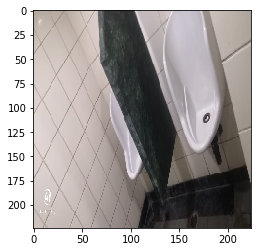

In [7]:
photo = encode_image("./testing_videos/WhatsApp Image 2019-11-21 at 1.28.05 AM.jpeg")

cap = pred_cap(photo)
print(cap)
# print(objects_str)

In [8]:
# Using LAPTOPS WEBCAM

vocals = pyttsx3.init()
voices = vocals.getProperty("voices")
vocals.setProperty("voice",voices[1].id)



# cam = cv2.VideoCapture("./testing_videos/index.jfif")
cam = cv2.VideoCapture(0)
i=0

while True:
    ret,frame = cam.read()
    key_pressed = cv2.waitKey(1)&0xFF
    if ret==False:
        print("Something went wrong")
        continue
    if key_pressed == ord('q'):
        break

    if i%30 == 0:
        photo = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        cv2.imwrite("C:/Users/asus/Desktop/test images/"+str(i)+".jpg", photo)

        photo = encode_image("C:/Users/asus/Desktop/test images/"+str(i)+".jpg")
        
        cap = pred_cap(photo)
        
#         -----------------------------------------------------------------------------------------
        
        
        
        img = frame
        height, width, channels = img.shape
        # detecting objects
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        # showing information on the screen

        boxes = []
        confidences = []
        class_ids = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    cv2.circle(img, (center_x, center_y), 10, (0, 255, 0), 2)

                    x = int(center_x - w/2)
                    y = int(center_y - h/2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        objects = []
        no_boxes_detected = len(boxes)
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_PLAIN
        for i in range(no_boxes_detected):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                objects.append(label)
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
                cv2.putText(img, label, (x, y+30), font, 3, (0,0,0), 3)


        cv2.imshow("Image", img)

#  ------------------------------------------------------------------------------------------------       
    
        objects_str = ",".join(objects)
        vocals.say(cap)
        vocals.say("There are "+ objects_str +" near you")
        vocals.runAndWait()

    #         cv2.imshow('VideoCapture',frame[:,::-1,:])
        print(cap)
        
    if i==5000:
        break
    i += 1
cam.release()
cv2.destroyAllWindows()

enter local IP address192.168.43.49:8080
man is laying on bed
man is laying on bed with his feet
man in black shirt is jumping on the wall
man in the bathroom with his teeth
man is holding pair of scissors
cat is laying on top of the mirror
black and white cat is sitting on top of cell phone
laptop and laptop and other items on desk
laptop and laptop and laptop and other items
laptop with note of scissors on it


KeyboardInterrupt: 

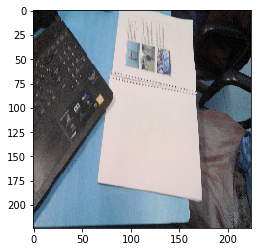

In [6]:

import requests
url =input("enter local IP address")
url = "http://"+url+"/shot.jpg"

vocals = pyttsx3.init()
voices = vocals.getProperty("voices")
vocals.setProperty("voice",voices[1].id)
hn=0

while True:
    img_resp = requests.get(url)
    img_array = np.array(bytearray(img_resp.content), dtype=np.uint8)
    frame = cv2.imdecode(img_array, -1)
    key_pressed = cv2.waitKey(1)&0xFF
    if key_pressed == ord('q'):
        break

    if hn%10 == 0:
        photo = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        cv2.imwrite("C:/Users/asus/Desktop/test images/"+str(hn)+".jpg", photo)

        photo = encode_image("C:/Users/asus/Desktop/test images/"+str(hn)+".jpg")
        
        cap = pred_cap(photo)
        
#         -----------------------------------------------------------------------------------------
        
        
        
        img = frame
        height, width, channels = img.shape
        # detecting objects
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        # showing information on the screen

        boxes = []
        confidences = []
        class_ids = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    cv2.circle(img, (center_x, center_y), 10, (0, 255, 0), 2)

                    x = int(center_x - w/2)
                    y = int(center_y - h/2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        objects = []
        no_boxes_detected = len(boxes)
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_PLAIN
        for i in range(no_boxes_detected):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                objects.append(label)
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
                cv2.putText(img, label, (x, y+30), font, 3, (0,0,0), 3)


        cv2.imshow("Image", img)

#  ------------------------------------------------------------------------------------------------       
    
        objects_str = ",".join(objects)
        vocals.say(cap)
        vocals.say("There are "+ objects_str +" near you")
        vocals.runAndWait()

    #         cv2.imshow('VideoCapture',frame[:,::-1,:])
        print(cap)
        
    if hn==5000:
        break
    hn += 1
cam.release()
cv2.destroyAllWindows()